In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def read_proteome(canonical_proteome):
    """
    Reads the proteome sequences from the FASTA file, filters X and U aa from proteome

    Parameters:
    canonical_proteome : str
        Path to the FASTA file containing the proteome sequences

    Returns:
    dict
        A dictionary where keys are protein IDs and values are sequences
        {prot1: 'PEPTIDERRRPEPTIDE...', ...}
    """
    sequences = {}  # {prot_id: sequence}
    with open(canonical_proteome, 'r') as f:
        prot_id = None
        seq_lines = []
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if prot_id:
                    sequence = ''.join(seq_lines)
                    if 'U' not in sequence and 'X' not in sequence:
                        sequences[prot_id] = sequence
                    seq_lines = []
                prot_id = line[1:].split()[0]
            else:
                seq_lines.append(line)
        if prot_id:
            sequence = ''.join(seq_lines)
            if 'U' not in sequence and 'X' not in sequence:
                sequences[prot_id] = sequence
    return sequences

In [4]:
sequences = read_proteome('/home/sander/apps/slim/general_data/UP000005640_9606_prot_id.fasta')
sequences

{'A0A075B706': 'TDKLIFGKGTRVTVEP',
 'A0A0G2JS06': 'MAWTPLLLLLLSHCTGSLSQPVLTQPTSLSASPGASARFTCTLRSGINVGTYRIYWYQQKPGSLPRYLLRYKSDSDKQQGSGVPSRFSGSKDASTNAGLLLISGLQSEDEADYYCAIWYSSTS',
 'A0A0J9YWL9': 'MAMNFGDHASGFRHDDVIRFINNEVLRNGGSPAFYTAFRSRPWNEVEDRLRAIVADPRVPRAIKRACTWSALALSVQVAARQQEELLYQVWWLQGHVEECQATSWALTSQLQQLRLEHEEVATQLHLTQAALQQVLNERDGLCGRLLEVERSMQVYPMPQDFVPGPEAGQYGPVAGTLNAEQSEAVATEAQGMPHSEAQVAAPTAVYYMPEPQSGRVQGMQPLLLMQAPHPVPFHMPSPMGLPYSTPLPPPVVMESAAAIAPQMPPAGIYPPGLWATVGSQEETAPPWDQKCHGQDGYPENFQGVYHPGDNRSCNQKEGSECPQGMTSQGDSSSHSLKKDPVMQEGTAPPEFSRSHSLEKKPVMPKEMVPLGDSNSHSLKKDPVVPKEIVPIGDSNSHSLTKNPVVHKEMVSLGDSNSHSMKKDPVMPQKMVPLGDSNSHSLKKDPMMCQEMVPLGDSNSHSLKKDPVVAQGTAPLMYSRRHSQKKVPMMPKEMVPLGESHSHSLKKDLVVPKELVPLGDSKSHRMKKDPVMPQKMVPLGDSRSHSLKKDPVMPQNMIPLEDSNSHSLKKDPVMPQNMIPLEDSNSHSLKKDPMMHQEMVPLGDSNSHSLKKDPVVPQDTAPLMFSRRHSLKKVPVMPKEMVPLGDSHSLKKDPVMPQNMVPLEDSNSHSLKKDPVVPQGTAPLMFSRRHSLKKVPVMPKEMVPLGDSNSHSLKKDPVVPQGTAPLMFSRRHSLKKVPVMPKEMVPLGDSHSLKKDPVMPQNMVPLEDSNSHSLKKDPVVPQGTAPLTFSRRHSLKKVPVVPQGTAS

In [5]:
def digest_protein(sequence, missed_cleavages=0, min_length=0, max_length=None):
    """
    Performs trypsin digestion on a sinlge protein sequence.

    **Input**:
    PEPTIDERPRRPEPTIDE
    **Output**:
    [('PEPTIDER', 0), ('PEPTIDERR', 0),..., ('RPEPTIDE', 9)]
    """
    cleavage_sites = []
    for i in range(len(sequence) - 1):
        if sequence[i] in ('K', 'R') and sequence[i+1] != 'P':
            cleavage_sites.append(i+1)
    cleavage_sites = [0] + cleavage_sites + [len(sequence)]
    peptides = []
    for start_idx in range(len(cleavage_sites)-1):
        for end_idx in range(start_idx+1, min(len(cleavage_sites), start_idx+missed_cleavages+2)):
            pep_start = cleavage_sites[start_idx]
            pep_end = cleavage_sites[end_idx]
            peptide = sequence[pep_start:pep_end]
            if min_length <= len(peptide) <= (max_length if max_length else len(peptide)):
                peptides.append((peptide, pep_start))
    return peptides # [(peptide, start_pos), ...]

def calculate_miscleavages(peptide_seq, protein_seq, start_pos):
    """
    Calculates the number of missed cleavages in a single peptide.

    **Input**:
    (peptide_seq = 'PEPTIDERPR', protein_seq = 'PEPTIDERPRRPEPTIDE', start_pos=0)
    **Output**:
    0
    """
    miscleavages = 0
    for i in range(1, len(peptide_seq)):
        abs_pos = start_pos + i -1  # Position in protein sequence
        if abs_pos+1 >= len(protein_seq):
            continue
        if protein_seq[abs_pos] in ('K', 'R') and protein_seq[abs_pos+1] != 'P':
            miscleavages +=1
    return miscleavages

def trypsin_digest(sequences, missed_cleavages, min_length, max_length):
    """
    Performs trypsin digestion on all protein sequences.
    
    **Input**:
    {prot1: 'PEPTIDERRRPEPTIDE...', ...}
    **Output**:
    [{'prot_id': prot1, 'sequence': PEPTIDERPR ,'miscleavages': 0,'peptide_length': 10,'start_pos': 0}, ...]
    """
    digested_peptides = []  # List of dicts with peptide info
    for prot_id, seq in sequences.items():
        peptides = digest_protein(seq, missed_cleavages, min_length, max_length)
        for peptide, start_pos in peptides:
            miscleavages = calculate_miscleavages(peptide, seq, start_pos)
            digested_peptides.append({
                'prot_id': prot_id,
                'sequence': peptide,
                'miscleavages': miscleavages,
                'peptide_length': len(peptide),
                'start_pos': start_pos
            })
    return digested_peptides

In [6]:
peptides = trypsin_digest(sequences = sequences, missed_cleavages = 2, min_length = 7, max_length = 30)

In [7]:
import pandas as pd

def load_all_predictions(prediction_files_info):
    """
    Loads prediction scores from multiple CSV files into a single dictionary.

    Parameters:
    - prediction_files_info (list): A list of dictionaries, each containing:
        - 'pred_csv': Path to the prediction CSV file ('prot_id', 'position', 'pred').
        # 'PTM' and 'threshold' are not needed here

    Returns:
    - dict: A dictionary mapping (prot_id, position_1_based) -> score.
    """
    all_scores = {}
    print("Loading prediction scores...")
    total_rows = 0
    for file_info in prediction_files_info:
        try:
            df = pd.read_csv(file_info['pred_csv'])
            # Ensure columns are correct type (position should be integer)
            df['position'] = df['position'].astype(int)
            df['pred'] = df['pred'].astype(float)
            print(f"  Loaded {len(df)} rows from {file_info['pred_csv']}")
            total_rows += len(df)
            # Populate dictionary, assuming 'position' is 1-based
            for _, row in df.iterrows():
                 # Check for duplicates, maybe keep the higher score? Or just overwrite?
                 # For now, let's overwrite, assuming files don't have overlapping positions
                 # for the same protein or that the last one read is desired.
                 key = (row['prot_id'], row['position'])
                 all_scores[key] = row['pred']
        except FileNotFoundError:
            print(f"  Warning: File not found - {file_info['pred_csv']}")
        except KeyError as e:
            print(f"  Warning: Missing expected column {e} in {file_info['pred_csv']}")
        except Exception as e:
             print(f"  Warning: Error processing {file_info['pred_csv']}: {e}")

    print(f"Finished loading predictions. Total entries: {len(all_scores)} (from {total_rows} rows read).")
    return all_scores

# --- Usage Example ---
# Define the source prediction files (WITHOUT threshold filtering here)
prediction_files = [
    {'pred_csv': "/home/sander/apps/slim/ptm_predictions/ST_Phospho_Human_Peptides_2,7,30_Preds.csv"},
    {'pred_csv': "/home/sander/apps/slim/ptm_predictions/Y_Phospho_Human_Peptides_2,7,30_Preds.csv"}
]

# Load all scores into the lookup dictionary
# This dictionary maps (protein_id, 1-based_protein_position) to score
prediction_scores_lookup = load_all_predictions(prediction_files)

# Example lookup:
print(prediction_scores_lookup.get(('A0A0G2JS06', 73))) # Should give score for Y at 73
print(prediction_scores_lookup.get(('A0A0G2JS06', 75))) # Should give score for S at 75


Loading prediction scores...
  Loaded 1217241 rows from /home/sander/apps/slim/ptm_predictions/ST_Phospho_Human_Peptides_2,7,30_Preds.csv
  Loaded 245372 rows from /home/sander/apps/slim/ptm_predictions/Y_Phospho_Human_Peptides_2,7,30_Preds.csv
Finished loading predictions. Total entries: 1462613 (from 1462613 rows read).
0.3189
0.2925


In [8]:
prediction_scores_lookup

{('A0A075B706', 1): 0.1249,
 ('A0A075B706', 10): 0.1613,
 ('A0A075B706', 13): 0.1005,
 ('A0A0G2JS06', 40): 0.0442,
 ('A0A0G2JS06', 42): 0.0299,
 ('A0A0G2JS06', 45): 0.0639,
 ('A0A0G2JS06', 51): 0.0347,
 ('A0A0G2JS06', 63): 0.2499,
 ('A0A0G2JS06', 73): 0.3189,
 ('A0A0G2JS06', 75): 0.2925,
 ('A0A0G2JS06', 81): 0.2317,
 ('A0A0G2JS06', 85): 0.0927,
 ('A0A0G2JS06', 88): 0.1137,
 ('A0A0G2JS06', 90): 0.0454,
 ('A0A0J9YWL9', 10): 0.0238,
 ('A0A0J9YWL9', 31): 0.4541,
 ('A0A0J9YWL9', 36): 0.0083,
 ('A0A0J9YWL9', 40): 0.0085,
 ('A0A0J9YWL9', 68): 0.0101,
 ('A0A0J9YWL9', 70): 0.0027,
 ('A0A0J9YWL9', 75): 0.003,
 ('A0A0J9YWL9', 123): 0.0044,
 ('A0A0J9YWL9', 128): 0.0039,
 ('A0A0J9YWL9', 313): 0.0737,
 ('A0A0J9YWL9', 320): 0.1735,
 ('A0A0J9YWL9', 327): 0.0654,
 ('A0A0J9YWL9', 328): 0.1541,
 ('A0A0J9YWL9', 332): 0.0459,
 ('A0A0J9YWL9', 333): 0.0484,
 ('A0A0J9YWL9', 334): 0.0558,
 ('A0A0J9YWL9', 336): 0.1423,
 ('A0A0J9YWL9', 347): 0.0956,
 ('A0A0J9YWL9', 353): 0.0455,
 ('A0A0J9YWL9', 355): 0.122,
 ('A

In [9]:
import math # To use float('nan')

def map_scores_to_peptide_sites(peptides, prediction_scores):
    """
    Maps prediction scores to potential phosphosites (S, T, Y) within digested peptides.

    Parameters:
    - peptides (list): List of peptide dictionaries from trypsin_digest.
        [{'prot_id': ..., 'sequence': ..., 'start_pos': ...}, ...]
    - prediction_scores (dict): Dictionary mapping (prot_id, position_1_based) -> score.

    Returns:
    - list: A list of dictionaries, where each dictionary represents one potential
            phosphosite site within a peptide.
            [{'peptide_index':..., 'prot_id':..., 'peptide_seq':..., 'peptide_start_pos':...,
              'site_residue':..., 'site_pos_in_peptide':..., 'site_pos_in_protein':..., 'score':...}, ...]
    """
    peptide_sites_data = []
    peptide_index = 0
    missing_score_count = 0
    total_potential_sites = 0

    print(f"Mapping scores to {len(peptides)} peptides...")

    for peptide_info in peptides:
        prot_id = peptide_info['prot_id']
        peptide_seq = peptide_info['sequence']
        # Ensure start_pos is integer (should be from digestion)
        start_pos = int(peptide_info['start_pos']) # 0-based start in protein

        has_potential_site = False # Flag to see if we process this peptide

        for site_pos_in_peptide, residue in enumerate(peptide_seq):
            if residue in ('S', 'T', 'Y'):
                has_potential_site = True
                total_potential_sites += 1
                # Calculate 1-based position in the protein
                site_pos_in_protein = start_pos + site_pos_in_peptide + 1

                # Lookup the score
                lookup_key = (prot_id, site_pos_in_protein)
                score = prediction_scores.get(lookup_key) # Returns None if not found

                if score is None:
                    score = float('nan') # Use NaN for missing scores
                    missing_score_count += 1
                    # Optional: Add a warning here if missing scores are unexpected
                    # print(f"Warning: No score found for {lookup_key} in peptide {peptide_seq}")


                site_data = {
                    'peptide_index': peptide_index,
                    'prot_id': prot_id,
                    'peptide_seq': peptide_seq,
                    'peptide_start_pos': start_pos,
                    'site_residue': residue,
                    'site_pos_in_peptide': site_pos_in_peptide, # 0-based in peptide
                    'site_pos_in_protein': site_pos_in_protein, # 1-based in protein
                    'score': score
                }
                peptide_sites_data.append(site_data)

        # Increment peptide_index only if the peptide contained potential sites
        # Or maybe increment for every peptide processed? Let's increment for every peptide.
        peptide_index += 1


    print(f"Finished mapping. Found {total_potential_sites} potential S/T/Y sites.")
    if missing_score_count > 0:
        print(f"Warning: {missing_score_count} sites had missing prediction scores (assigned NaN).")
    print(f"Generated {len(peptide_sites_data)} site entries.")

    return peptide_sites_data

In [10]:
# --- Step 4: Map Scores to Peptide Sites ---
peptide_sites_list = map_scores_to_peptide_sites(peptides, prediction_scores_lookup)

# --- Step 5: Convert to DataFrame for Analysis (Recommended) ---
sites_df = pd.DataFrame(peptide_sites_list)

Mapping scores to 2068637 peptides...
Finished mapping. Found 5118799 potential S/T/Y sites.
Generated 5118799 site entries.


In [11]:
sites_df.head()

,peptide_index,prot_id,peptide_seq,peptide_start_pos,site_residue,site_pos_in_peptide,site_pos_in_protein,score
0,0,A0A075B706,TDKLIFGK,0,T,0,1,0.1249
1,1,A0A075B706,TDKLIFGKGTR,0,T,0,1,0.1249
2,1,A0A075B706,TDKLIFGKGTR,0,T,9,10,0.1613
3,2,A0A075B706,LIFGKGTR,3,T,6,10,0.1613
4,3,A0A075B706,LIFGKGTRVTVEP,3,T,6,10,0.1613


# Clustering analysis

Original number of site entries: 5118799
Number of site entries after dropping NaNs: 5118494
Total unique peptides with scorable sites: 1775838

Comparing Prediction vs Random Filtering across 11 thresholds...
  Processing threshold: 0.0
    Prediction Filter: Kept 5118494 sites.
  Processing threshold: 0.1
    Prediction Filter: Kept 1560080 sites.
  Processing threshold: 0.2
    Prediction Filter: Kept 1063738 sites.
  Processing threshold: 0.3
    Prediction Filter: Kept 801337 sites.
  Processing threshold: 0.4
    Prediction Filter: Kept 627957 sites.
  Processing threshold: 0.5
    Prediction Filter: Kept 498780 sites.
  Processing threshold: 0.6
    Prediction Filter: Kept 391864 sites.
  Processing threshold: 0.7
    Prediction Filter: Kept 296704 sites.
  Processing threshold: 0.8
    Prediction Filter: Kept 204735 sites.
  Processing threshold: 0.9
    Prediction Filter: Kept 107865 sites.
  Processing threshold: 1.0
    Prediction Filter: Kept 0 sites.

--- Comparison Result

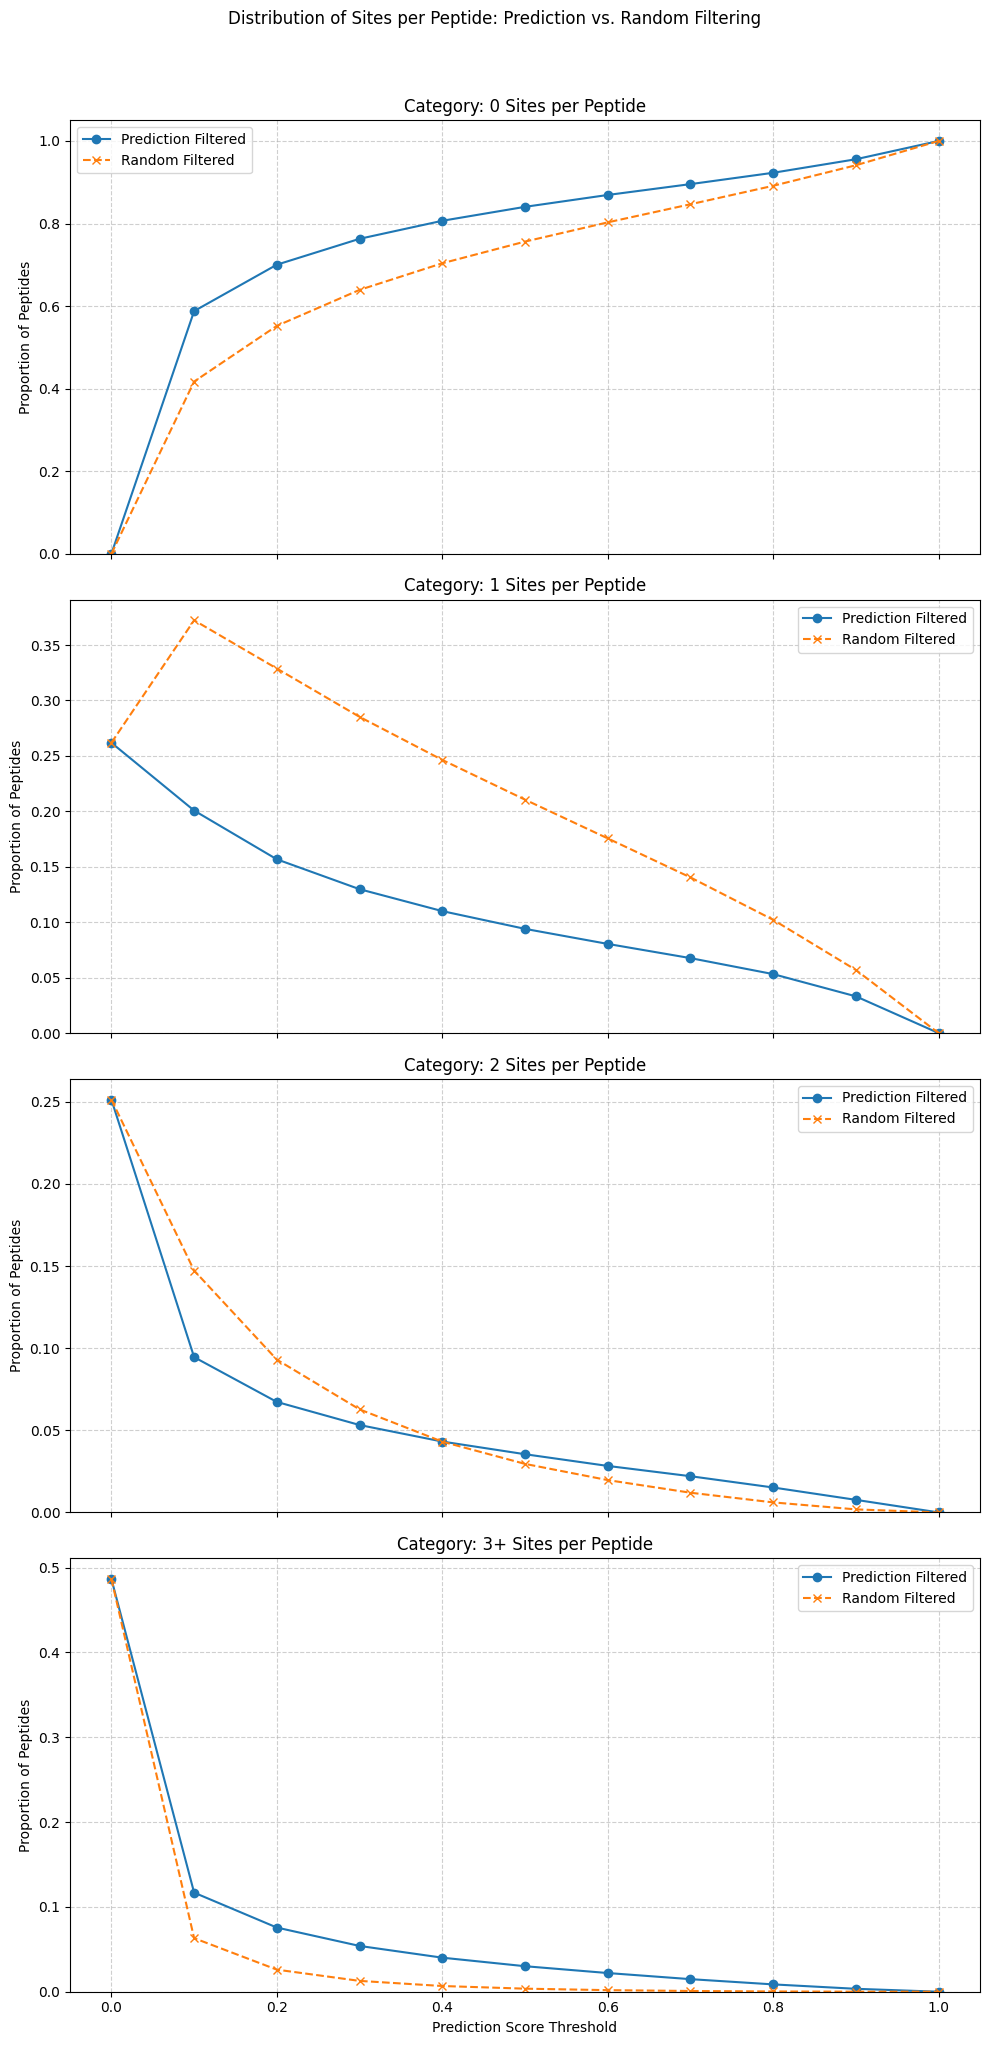

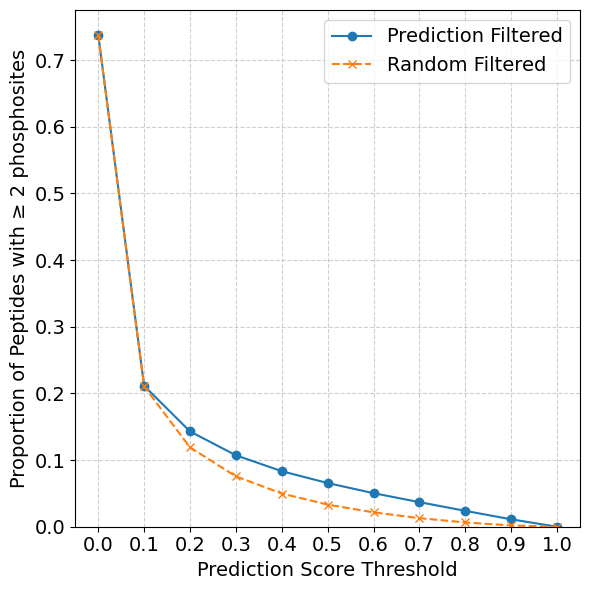


--- Interpretation ---
The first set of plots compares the proportion of peptides having exactly 0, 1, 2, or 3+ sites after filtering.
The second plot focuses on peptides having 2 or more sites (prone to combinatorial expansion).
If Prediction Filtering causes more clustering than Random Filtering (for the same # of sites):
  - Prediction line should be LOWER for '0 Sites' category.
  - Prediction line should be HIGHER for '2 Sites' and '3+ Sites' categories.
  - The second plot should show Prediction line consistently above the Random line.


In [20]:
# --- Parameters ---
thresholds_to_test = np.round(np.arange(0.0, 1.1, 0.1), 1) # 0.0, 0.1, ..., 0.9
MAX_SITES_CATEGORY = 2 # Categories: 0 sites, 1 site, 2 sites, and 3+ sites
RANDOM_STATE = 42

# --- Data Preparation ---
print(f"Original number of site entries: {len(sites_df)}")
sites_df_cleaned = sites_df.dropna(subset=['score']).copy()
print(f"Number of site entries after dropping NaNs: {len(sites_df_cleaned)}")

# Check if there are any sites left
if sites_df_cleaned.empty:
    print("Error: No site entries left after removing NaNs. Cannot proceed.")
    # Exit or handle appropriately
else:
    # Get the base set of peptides and total count
    all_peptide_indices = sites_df_cleaned['peptide_index'].unique()
    total_peptide_base = len(all_peptide_indices)
    print(f"Total unique peptides with scorable sites: {total_peptide_base}")

    # --- Analysis Loop ---
    comparison_results = []

    print(f"\nComparing Prediction vs Random Filtering across {len(thresholds_to_test)} thresholds...")

    for threshold in thresholds_to_test:
        print(f"  Processing threshold: {threshold:.1f}")

        # --- Step 2a: Prediction Filtering ---
        predicted_sites = sites_df_cleaned[sites_df_cleaned['score'] >= threshold]
        num_sites_to_keep = len(predicted_sites)
        print(f"    Prediction Filter: Kept {num_sites_to_keep} sites.")

        result_row = {'threshold': threshold, 'sites_kept': num_sites_to_keep}

        # Calculate distribution for Prediction Filter
        if num_sites_to_keep > 0:
            pred_sites_per_peptide = predicted_sites.groupby('peptide_index').size()
            pred_dist_counts = pred_sites_per_peptide.value_counts()
            num_peptides_with_sites_pred = len(pred_sites_per_peptide)
        else:
            pred_dist_counts = pd.Series(dtype=int) # Empty series
            num_peptides_with_sites_pred = 0

        # --- Step 2b: Random Filtering (Control) ---
        if num_sites_to_keep > 0:
            # Ensure we don't try to sample more than available
            if num_sites_to_keep > len(sites_df_cleaned):
                 print(f"Warning: Threshold {threshold} keeps more sites ({num_sites_to_keep}) than available ({len(sites_df_cleaned)}). Adjusting random sample size.")
                 num_sites_to_keep = len(sites_df_cleaned) # Should only happen at threshold 0.0

            random_sites = sites_df_cleaned.sample(n=num_sites_to_keep, random_state=RANDOM_STATE)
            rand_sites_per_peptide = random_sites.groupby('peptide_index').size()
            rand_dist_counts = rand_sites_per_peptide.value_counts()
            num_peptides_with_sites_rand = len(rand_sites_per_peptide)
        else:
            # If prediction kept 0, random also keeps 0
            rand_dist_counts = pd.Series(dtype=int) # Empty series
            num_peptides_with_sites_rand = 0

        # --- Step 2c: Normalize & Store (Calculate proportions) ---
        # Helper function to get proportions including category 0 and grouping higher counts
        def calculate_proportions(dist_counts, num_peptides_with_sites, total_peptides, max_category):
            proportions = {}
            # Calculate proportion of peptides with 0 sites
            proportions[0] = (total_peptides - num_peptides_with_sites) / total_peptides if total_peptides > 0 else 0
            # Calculate proportions for explicit categories (1 to max_category)
            prop_sum_explicit = 0
            for i in range(1, max_category + 1):
                count = dist_counts.get(i, 0)
                prop = count / total_peptides if total_peptides > 0 else 0
                proportions[i] = prop
                prop_sum_explicit += prop
            # Calculate proportion for higher category (max_category + 1)+
            prop_higher = 0
            for sites, count in dist_counts.items():
                if sites > max_category:
                    prop_higher += count / total_peptides if total_peptides > 0 else 0
            # Ensure sum is close to 1 (handle potential float issues if needed)
            # prop_higher = max(0, 1.0 - proportions[0] - prop_sum_explicit)
            proportions[f'{max_category + 1}+'] = prop_higher
            # Also calculate proportion >= 2 for direct comparison
            prop_ge_2 = sum(proportions[k] for k in proportions if isinstance(k, int) and k >= 2 or isinstance(k, str) and '+' in k) # Sum 2, 3+
            proportions['>=2'] = prop_ge_2
            return proportions

        pred_proportions = calculate_proportions(pred_dist_counts, num_peptides_with_sites_pred, total_peptide_base, MAX_SITES_CATEGORY)
        rand_proportions = calculate_proportions(rand_dist_counts, num_peptides_with_sites_rand, total_peptide_base, MAX_SITES_CATEGORY)

        # Store flattened results
        for cat, prop in pred_proportions.items():
            result_row[f'pred_prop_{cat}'] = prop
        for cat, prop in rand_proportions.items():
            result_row[f'rand_prop_{cat}'] = prop

        comparison_results.append(result_row)

    # --- Process and Plot Results ---
    comp_df = pd.DataFrame(comparison_results)
    comp_df = comp_df.set_index('threshold')

    print("\n--- Comparison Results Summary (Proportions) ---")
    print(comp_df)

    # --- Visualization ---
    categories_to_plot = [0, 1, 2, f'{MAX_SITES_CATEGORY + 1}+']
    n_categories = len(categories_to_plot)

    fig, axes = plt.subplots(n_categories, 1, figsize=(10, 5 * n_categories), sharex=True)
    if n_categories == 1: axes = [axes] # Make it iterable if only one subplot

    fig.suptitle('Distribution of Sites per Peptide: Prediction vs. Random Filtering', y=1.02)

    for i, category in enumerate(categories_to_plot):
        ax = axes[i]
        pred_col = f'pred_prop_{category}'
        rand_col = f'rand_prop_{category}'

        ax.plot(comp_df.index, comp_df[pred_col], marker='o', linestyle='-', label='Prediction Filtered')
        ax.plot(comp_df.index, comp_df[rand_col], marker='x', linestyle='--', label='Random Filtered')

        ax.set_ylabel("Proportion of Peptides")
        ax.set_title(f'Category: {category} Sites per Peptide')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_ylim(bottom=0)

    axes[-1].set_xlabel("Prediction Score Threshold")
    plt.tight_layout()
    plt.show()

    # --- Plot focusing on >= 2 sites ---
    plt.figure(figsize=(6, 6))
    plt.plot(comp_df.index, comp_df['pred_prop_>=2'], marker='o', linestyle='-', label='Prediction Filtered')
    plt.plot(comp_df.index, comp_df['rand_prop_>=2'], marker='x', linestyle='--', label='Random Filtered')
    plt.xlabel("Prediction Score Threshold", fontsize=14)
    plt.ylabel("Proportion of Peptides with ≥ 2 phosphosites", fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.ylim(bottom=0)
    plt.xticks(np.arange(0.0, 1.1, 0.1), fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()


    print("\n--- Interpretation ---")
    print(f"The first set of plots compares the proportion of peptides having exactly 0, 1, 2, or {MAX_SITES_CATEGORY+1}+ sites after filtering.")
    print("The second plot focuses on peptides having 2 or more sites (prone to combinatorial expansion).")
    print("If Prediction Filtering causes more clustering than Random Filtering (for the same # of sites):")
    print("  - Prediction line should be LOWER for '0 Sites' category.")
    print("  - Prediction line should be HIGHER for '2 Sites' and '3+ Sites' categories.")
    print("  - The second plot should show Prediction line consistently above the Random line.")